In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
MAX_BATCH_SIZE = 9
ORG_NAME = "PancakeSwap"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-06-27"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3119 non-null   object        
 1   author             3119 non-null   object        
 2   date               3119 non-null   datetime64[us]
 3   start              3119 non-null   datetime64[us]
 4   end                3119 non-null   datetime64[us]
 5   platform_proposal  3119 non-null   object        
 6   title              3119 non-null   object        
 7   description        3119 non-null   object        
dtypes: datetime64[us](3), object(5)
memory usage: 195.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532830 entries, 0 to 532829
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        532830 non-null  object        
 1   proposal  532830 non-n

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x8b017905dc96b38f817473dc885f84d4c76bc113,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:14:46,1
1,0x9e882c739493886ab2865803432d3140b6473bfc,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:41:42,1
2,0x1e5c8c04e56f88c09ad775e43a164de264d6dad7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:42:56,1
3,0x977e0c1005dff8749f8cac22f4df0bd5f013d1a7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:54:31,1
4,0x1ce49ed469b2c0edf50b574cea9a196bbe23655b,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 16:02:34,1
...,...,...,...,...
532825,0xd554664fb7e5c4ad17a5f32343843f30eb4c093d,718fe10e-25cf-5c87-b966-99e1ca411fb1,2023-07-20 03:06:58,1
532826,0x71c9137eb29ce52e7bdab9ee5cac25208f910665,718fe10e-25cf-5c87-b966-99e1ca411fb1,2023-07-20 03:16:03,1
532827,0x843146d71d57af0e731f85db1f094643776c8e91,718fe10e-25cf-5c87-b966-99e1ca411fb1,2023-07-20 03:33:17,1
532828,0x8dcad3b779415f519c21bb42c9a6743e8cef1c5d,718fe10e-25cf-5c87-b966-99e1ca411fb1,2023-07-20 03:47:32,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-05-31 00:00:00'),
 Timestamp('2023-06-03 00:00:00'),
 Timestamp('2023-06-06 00:00:00'),
 Timestamp('2023-06-09 00:00:00'),
 Timestamp('2023-06-12 00:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-06-18 00:00:00'),
 Timestamp('2023-06-21 00:00:00'),
 Timestamp('2023-06-24 00:00:00'),
 Timestamp('2023-06-27 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/PancakeSwap/hparams-pln-similarity_3d_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-05-31,all-mpnet-base-v2,7d,0.745167,0.005197,205,0.082927,0.048780,0.037073,0.033171,...,0.155670,0.236190,0.999512,0.860224,0.666094,0.654500,0.550795,0.516298,0.539516,0.543856
1,2023-05-31,all-mpnet-base-v2,14d,1.056149,0.006073,254,0.090551,0.052493,0.044882,0.035433,...,0.198572,0.330073,0.999606,0.769597,0.661732,0.650688,0.576973,0.510166,0.532494,0.451781
2,2023-05-31,all-mpnet-base-v2,21d,1.575587,0.006910,277,0.111913,0.057762,0.048375,0.041516,...,0.223537,0.352510,0.999484,0.846567,0.730825,0.708566,0.625038,0.580710,0.597995,0.480603
3,2023-05-31,all-mpnet-base-v2,30d,2.308136,0.008553,323,0.160991,0.071207,0.059443,0.045820,...,0.232706,0.328644,0.999423,0.874655,0.772522,0.696029,0.659552,0.629028,0.641729,0.538544
4,2023-05-31,all-mpnet-base-v2,60d,25.245611,0.017194,423,0.115839,0.088258,0.066194,0.046809,...,0.276478,0.396139,0.999559,0.855202,0.732561,0.666614,0.611753,0.591990,0.605991,0.673858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-06-27,all-MiniLM-L6-v2,21d,1.248817,0.003988,71,0.056338,0.061033,0.064789,0.040845,...,0.219953,0.263615,0.963380,0.625000,0.464815,0.465152,0.465152,0.465152,0.465152,0.191705
276,2023-06-27,all-MiniLM-L6-v2,30d,2.460859,0.005276,82,0.060976,0.048780,0.053659,0.035366,...,0.212805,0.241463,0.942683,0.633333,0.511111,0.471212,0.480303,0.480303,0.480303,0.199473
277,2023-06-27,all-MiniLM-L6-v2,60d,4.900687,0.008748,113,0.123894,0.100295,0.081416,0.049558,...,0.267158,0.304695,0.976106,0.534127,0.544444,0.578056,0.596944,0.596944,0.596944,0.241527
278,2023-06-27,all-MiniLM-L6-v2,90d,27.716234,0.016634,123,0.089431,0.086721,0.071545,0.042276,...,0.207562,0.248506,0.982656,0.449495,0.421171,0.452004,0.463115,0.463115,0.463115,0.247699


<Axes: xlabel='window_size', ylabel='map@10'>

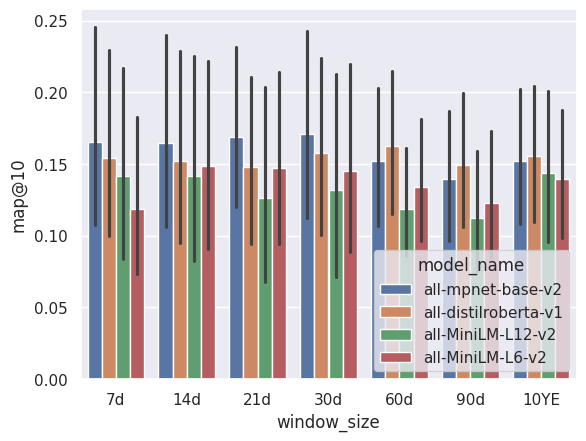

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
7d,all-mpnet-base-v2,0.642529,0.106306,0.086339,0.029960,0.055171,0.065176,0.115705,0.158171,0.173005,0.227289,0.222189,0.322206,0.997818,0.436588,0.467403,0.488939
21d,all-mpnet-base-v2,1.758815,0.091408,0.070970,0.024130,0.106209,0.128500,0.218700,0.158015,0.172507,0.217797,0.262537,0.372963,0.992977,0.509567,0.514285,0.538625
30d,all-mpnet-base-v2,2.526224,0.089834,0.070398,0.023620,0.115562,0.140102,0.243197,0.155979,0.170902,0.215860,0.244017,0.352541,0.988972,0.509070,0.520743,0.542515
14d,all-mpnet-base-v2,1.200136,0.091109,0.074653,0.025492,0.084489,0.105145,0.183031,0.154806,0.170511,0.218763,0.232356,0.351926,0.996410,0.505941,0.511673,0.531935
7d,all-distilroberta-v1,0.611224,0.091655,0.080334,0.029899,0.051387,0.062450,0.114328,0.146891,0.163031,0.219122,0.192532,0.304133,0.997126,0.454356,0.484674,0.505820
60d,all-distilroberta-v1,21.399203,0.084283,0.065415,0.022858,0.138064,0.168382,0.299632,0.145870,0.160117,0.205797,0.216833,0.328472,0.989098,0.500686,0.523908,0.549540
14d,all-MiniLM-L6-v2,1.080770,0.084080,0.069726,0.025339,0.081271,0.101597,0.180764,0.143066,0.159018,0.208422,0.211055,0.328900,0.989723,0.465144,0.491831,0.513517
21d,all-MiniLM-L6-v2,1.615186,0.081555,0.068435,0.024009,0.095516,0.123529,0.214559,0.137515,0.156834,0.203219,0.221685,0.360573,0.987942,0.445476,0.468684,0.491980
30d,all-distilroberta-v1,2.526535,0.082721,0.064535,0.023719,0.107253,0.127091,0.238388,0.144405,0.156298,0.204694,0.215725,0.299782,0.992894,0.480030,0.504463,0.525562


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/models/plnsim-best-avg_3d_normalize.parquet


/tmp/ipykernel_3804911/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-05-31,7d,all-mpnet-base-v2,0.745167,0.005197,205,0.082927,0.048780,0.037073,0.033171,0.041951,0.032537,0.034000,...,0.155670,0.236190,0.999512,0.860224,0.666094,0.654500,0.550795,0.516298,0.539516,0.543856
2023-06-03,7d,all-mpnet-base-v2,1.244152,0.003751,123,0.040650,0.065041,0.097561,0.101626,0.101355,0.037561,0.015291,...,0.275545,0.409371,1.000000,0.606667,0.413735,0.312721,0.363360,0.401187,0.415579,0.250732
2023-06-06,7d,all-mpnet-base-v2,0.853376,0.003297,94,0.053191,0.081560,0.082979,0.102128,0.107092,0.035851,0.017301,...,0.274523,0.414340,0.994681,0.514286,0.275925,0.262163,0.320238,0.357782,0.361894,0.229722
2023-06-09,7d,all-mpnet-base-v2,0.320271,0.002414,61,0.065574,0.081967,0.088525,0.100000,0.114754,0.035574,0.014815,...,0.293269,0.504212,1.000000,0.316964,0.294087,0.287092,0.372071,0.399412,0.404620,0.198709
2023-06-12,7d,all-mpnet-base-v2,0.656878,0.002584,52,0.019231,0.076923,0.092308,0.088462,0.102564,0.029423,0.004098,...,0.195175,0.471820,1.000000,0.500000,0.238988,0.241342,0.284087,0.322844,0.322844,0.182438
2023-06-15,7d,all-mpnet-base-v2,0.707480,0.004021,105,0.352381,0.152381,0.118095,0.070476,0.057778,0.029429,0.110778,...,0.489455,0.570748,0.987498,0.920957,0.885598,0.817060,0.826964,0.829346,0.830177,0.291987
2023-06-18,7d,all-mpnet-base-v2,0.496499,0.003156,62,0.145161,0.107527,0.096774,0.056452,0.044086,0.027097,0.042857,...,0.224435,0.279543,1.000000,0.474815,0.448556,0.419706,0.424412,0.424412,0.440882,0.210041
2023-06-21,7d,all-mpnet-base-v2,0.527743,0.003374,58,0.155172,0.120690,0.120690,0.084483,0.067816,0.029138,0.038462,...,0.318765,0.366652,0.998185,0.444444,0.448696,0.471147,0.481563,0.488142,0.488142,0.221955
2023-06-24,7d,all-mpnet-base-v2,0.408690,0.003388,93,0.376344,0.240143,0.191398,0.112903,0.078853,0.024516,0.093085,...,0.533513,0.544180,1.000000,0.556122,0.649524,0.660655,0.665417,0.666607,0.667798,0.239026


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/models/plnsim-best-val_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-31,all-distilroberta-v1,10YE,796.579134,0.061200,0.050600,0.027660,0.211528,0.234256,0.421919,0.195353,0.203322,0.252304,0.222704,0.287476,0.997252,0.762070,0.715486,0.727787
2023-06-03,all-mpnet-base-v2,14d,1.529015,0.085714,0.087831,0.028730,0.103940,0.134299,0.227924,0.124311,0.145179,0.200400,0.307074,0.427820,1.000000,0.410775,0.359082,0.414748
2023-06-06,all-MiniLM-L6-v2,14d,1.228674,0.120930,0.101163,0.026802,0.142021,0.167136,0.257021,0.173445,0.191037,0.243270,0.350640,0.464173,1.000000,0.255122,0.352851,0.385796
2023-06-09,all-MiniLM-L12-v2,7d,0.148124,0.104918,0.116393,0.035574,0.032509,0.051720,0.090924,0.096985,0.134784,0.200897,0.171775,0.404049,1.000000,0.343684,0.401465,0.450507
2023-06-12,all-mpnet-base-v2,21d,1.818864,0.102041,0.076871,0.020476,0.116658,0.135434,0.227439,0.125909,0.138248,0.184892,0.344692,0.430405,1.000000,0.322430,0.365298,0.390412
2023-06-15,all-MiniLM-L12-v2,7d,0.498463,0.120000,0.075238,0.029714,0.133632,0.139282,0.176264,0.396360,0.401357,0.430578,0.461995,0.525694,0.999323,0.822670,0.812721,0.821096
2023-06-18,all-distilroberta-v1,60d,24.818800,0.095484,0.060645,0.022452,0.156439,0.169139,0.300501,0.173452,0.179117,0.223727,0.236319,0.287254,0.991935,0.538796,0.544630,0.552249
2023-06-21,all-mpnet-base-v2,7d,0.527743,0.120690,0.084483,0.029138,0.047009,0.055312,0.100062,0.140316,0.154862,0.199971,0.223362,0.318765,0.998185,0.471147,0.481563,0.488142
2023-06-24,all-mpnet-base-v2,30d,2.650503,0.184279,0.109170,0.022009,0.250704,0.266661,0.330396,0.369748,0.381282,0.405842,0.493699,0.566434,0.991266,0.829881,0.819677,0.826028


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,164.473426,0.112684,0.083608,0.026611,0.146196,0.162611,0.256599,0.201072,0.214413,0.259695,0.314511,0.406811,0.997796,0.532764,0.543800,0.565056
std,338.094810,0.032517,0.020779,0.004564,0.078606,0.077513,0.118363,0.102418,0.097291,0.087137,0.105247,0.095901,0.003400,0.211388,0.184450,0.171723
min,0.148124,0.061200,0.050600,0.020476,0.032509,0.051720,0.090924,0.096985,0.134784,0.184892,0.171775,0.287254,0.991266,0.255122,0.352851,0.385796
25%,0.702976,0.097123,0.074073,0.022727,0.107120,0.134583,0.189058,0.129511,0.147600,0.200524,0.226601,0.328082,0.997485,0.360457,0.374340,0.423687
50%,1.673939,0.112459,0.080677,0.027231,0.137826,0.153209,0.242473,0.173448,0.185077,0.233499,0.319960,0.415934,0.999661,0.504971,0.513096,0.520195
75%,19.276726,0.120870,0.097830,0.029036,0.197756,0.217976,0.322922,0.209970,0.212034,0.254380,0.349153,0.455731,1.000000,0.714318,0.682922,0.694290
max,814.934945,0.184279,0.116393,0.035574,0.267520,0.272870,0.433535,0.396360,0.401357,0.430578,0.493699,0.566434,1.000000,0.829881,0.819677,0.826028


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/models/plnsim-best-test_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-06-03,all-distilroberta-v1,10YE,800.803653,0.049541,0.067278,0.026789,0.084227,0.151109,0.334065,0.061119,0.085851,0.140626,0.111775,0.307481,0.996942,0.357240,0.395398,0.461573
2023-06-06,all-mpnet-base-v2,14d,1.355876,0.067442,0.071512,0.026802,0.054160,0.077710,0.202781,0.059457,0.074622,0.141680,0.114040,0.218250,1.000000,0.310345,0.373360,0.411982
2023-06-09,all-MiniLM-L6-v2,14d,1.116391,0.067089,0.090506,0.022089,0.062162,0.136071,0.208998,0.074028,0.123264,0.164195,0.145791,0.534490,1.000000,0.361437,0.418910,0.458412
2023-06-12,all-MiniLM-L12-v2,7d,0.446455,0.053846,0.086538,0.029423,0.011881,0.028434,0.073366,0.032628,0.065231,0.139729,0.055875,0.255917,1.000000,0.200785,0.297680,0.361070
2023-06-15,all-mpnet-base-v2,21d,2.046464,0.102591,0.063212,0.023420,0.211708,0.221529,0.294815,0.339182,0.346039,0.375997,0.406541,0.457567,0.988468,0.872572,0.879758,0.868865
2023-06-18,all-MiniLM-L12-v2,7d,0.601962,0.058065,0.051613,0.027097,0.030820,0.042381,0.102571,0.080403,0.092623,0.140737,0.110511,0.224973,1.000000,0.439792,0.449792,0.494792
2023-06-21,all-distilroberta-v1,60d,17.485341,0.086792,0.054717,0.028994,0.116452,0.124323,0.256658,0.139403,0.142718,0.189537,0.179398,0.210634,0.950009,0.529147,0.508110,0.512799
2023-06-24,all-mpnet-base-v2,7d,0.408690,0.191398,0.112903,0.024516,0.102328,0.108380,0.136888,0.364755,0.378089,0.402712,0.466948,0.533513,1.000000,0.660655,0.665417,0.667798
2023-06-27,all-mpnet-base-v2,30d,2.531959,0.097561,0.062195,0.019878,0.108009,0.122225,0.209733,0.165091,0.176551,0.216799,0.262195,0.331707,0.975610,0.640625,0.614706,0.614706


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,91.866310,0.086036,0.073386,0.025445,0.086861,0.112462,0.202208,0.146230,0.164998,0.212446,0.205897,0.341615,0.990114,0.485844,0.511459,0.539111
std,265.906908,0.043823,0.019748,0.003202,0.058734,0.058501,0.086476,0.123800,0.117356,0.103934,0.143523,0.133256,0.017164,0.209805,0.180496,0.155746
min,0.408690,0.049541,0.051613,0.019878,0.011881,0.028434,0.073366,0.032628,0.065231,0.139729,0.055875,0.210634,0.950009,0.200785,0.297680,0.361070
25%,0.601962,0.058065,0.062195,0.023420,0.054160,0.077710,0.136888,0.061119,0.085851,0.140737,0.111775,0.224973,0.988468,0.357240,0.395398,0.458412
50%,1.355876,0.067442,0.067278,0.026789,0.084227,0.122225,0.208998,0.080403,0.123264,0.164195,0.145791,0.307481,1.000000,0.439792,0.449792,0.494792
75%,2.531959,0.097561,0.086538,0.027097,0.108009,0.136071,0.256658,0.165091,0.176551,0.216799,0.262195,0.457567,1.000000,0.640625,0.614706,0.614706
max,800.803653,0.191398,0.112903,0.029423,0.211708,0.221529,0.334065,0.364755,0.378089,0.402712,0.466948,0.534490,1.000000,0.872572,0.879758,0.868865
